In [0]:
# Start a Spark session.
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName('PySparkMLDemo') \
    .getOrCreate()

In [0]:
# Goal: Create a dataframe with our NYC taxi data.
# I'll leverage Spark to read in our dataset.

# Import our full dataset with Spark SQL.
df = spark.sql('SELECT * FROM taxi_trips_perm')

# Filtering here -- e.g. WHERE fare_amount > 0 -- is often easier and faster than using Spark.

In [0]:
df.printSchema()

root
 |-- VendorID: integer (nullable = true)
 |-- tpep_pickup_datetime: timestamp (nullable = true)
 |-- tpep_dropoff_datetime: timestamp (nullable = true)
 |-- passenger_count: long (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: long (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: integer (nullable = true)
 |-- DOLocationID: integer (nullable = true)
 |-- payment_type: long (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)
 |-- Airport_fee: double (nullable = true)



In [0]:
print('Number of rows: ', df.count())

Number of rows:  3833771


In [0]:
# df.head()

df.show(5)

# Note: This is not user-friendly.

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|Airport_fee|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+
|       2| 2024-10-01 00:30:44|  2024-10-01 00:48:26|              1|          3.0|         1|                 N|         162|         246|           1|       18.4|  1.0|    0.5|       1.

In [0]:
# How do we filter rows?

# Remember that we don't have inplace methods, so we need to manually
# overwrite objects or create new ones.

filtered_df = df.filter(df.fare_amount > 0)

# It all happens here: remember, Spark is lazy!
filtered_df.show(5)

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|Airport_fee|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+
|       2| 2024-10-01 00:30:44|  2024-10-01 00:48:26|              1|          3.0|         1|                 N|         162|         246|           1|       18.4|  1.0|    0.5|       1.

In [0]:
# Does passenger count correlate with fare amount?

agg_df = filtered_df.groupBy('passenger_count').avg('fare_amount')
agg_df.orderBy('passenger_count', ascending=False).show()

+---------------+------------------+
|passenger_count|  avg(fare_amount)|
+---------------+------------------+
|              9|            90.678|
|              8| 67.64466666666667|
|              7|              71.9|
|              6|19.458295608434867|
|              5| 20.46014816740322|
|              4|26.257116339075743|
|              3| 22.77627218119713|
|              2|23.495920769823755|
|              1|19.799413976360647|
|              0| 19.83743843742998|
|           null|20.032276619203568|
+---------------+------------------+



Out[29]: (array([-2.,  0.,  2.,  4.,  6.,  8., 10.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

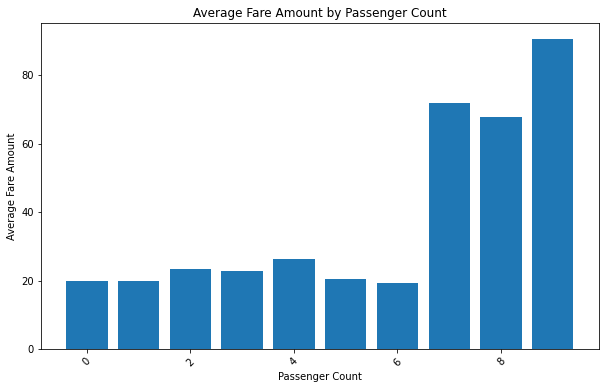

In [0]:
# First convert your PySpark DataFrame to Pandas
pandas_df = agg_df.toPandas()

# Create matplotlib visualization
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
# Use the column names directly from the pandas DataFrame
plt.bar(pandas_df['passenger_count'], pandas_df['avg(fare_amount)'])
plt.title('Average Fare Amount by Passenger Count')
plt.xlabel('Passenger Count')
plt.ylabel('Average Fare Amount')
plt.xticks(rotation=45)

In [0]:
# Does passenger count correlate with fare amount?

from pyspark.sql.functions import *

# Put these together!
results = df.filter(df.fare_amount > 0) \
            .groupBy('passenger_count') \
            .agg(
                mean('fare_amount').alias('Average Fare'),
                max('fare_amount').alias('Maximum Fare')
            ) \
            .orderBy('passenger_count')

# Remember: Lazy!
results.show()

+---------------+------------------+------------+
|passenger_count|      Average Fare|Maximum Fare|
+---------------+------------------+------------+
|           null|20.032276619203568|      525.59|
|              0| 19.83743843742998|       700.0|
|              1|19.799413976360647|       920.0|
|              2|23.495920769823755|      1680.2|
|              3| 22.77627218119713|       511.2|
|              4|26.257116339075743|       795.0|
|              5| 20.46014816740322|       360.0|
|              6|19.458295608434867|       175.9|
|              7|              71.9|        78.8|
|              8| 67.64466666666667|       89.49|
|              9|            90.678|       93.39|
+---------------+------------------+------------+



In [0]:
# In order to do ML, we need to drop our NAs.
df = df.dropna()

In [0]:
# ML in PySpark!
# Goal: Predict fare_amount from rateCodeId, passenger_count, trip_distance, and Airport_fee.

# 1. rateCodeID should be treated as categorical --> StringIndexer
# 2. We must assemble all of our input features together --> VectorAssembler

from pyspark.ml.feature import StringIndexer, VectorAssembler 


In [0]:
# Convert rateCodeID to categorical

indexer = StringIndexer(inputCol='rateCodeId',
                        outputCol='rateCodeId_index')

indexed_data = indexer.fit(df).transform(df)

In [0]:
# In order to do ML in PySpark, we have to assemble all of our features together. (VectorAssembler)

# Define input columns.
input_columns = ['rateCodeId_index', 'passenger_count', 'trip_distance', 'Airport_fee']

# Assemble our features together.
assembler = VectorAssembler(inputCols=input_columns
                            ,outputCol='features')

final_data = assembler.transform(indexed_data).select('features', 'fare_amount')

In [0]:
final_data.show()

+-------------------+-----------+
|           features|fare_amount|
+-------------------+-----------+
|  [0.0,1.0,3.0,0.0]|       18.4|
|  [0.0,1.0,2.2,0.0]|       14.2|
|  [0.0,1.0,2.7,0.0]|       13.5|
|  [0.0,1.0,3.1,0.0]|       14.2|
|      (4,[1],[1.0])|        3.0|
| [0.0,2.0,0.97,0.0]|        7.2|
|  [0.0,1.0,1.3,0.0]|        7.9|
|  [0.0,1.0,0.5,0.0]|        5.1|
|      (4,[2],[1.1])|        7.2|
|  [0.0,1.0,2.2,0.0]|       11.4|
|  [0.0,1.0,0.6,0.0]|        5.1|
|  [0.0,1.0,0.9,0.0]|        7.9|
| [0.0,1.0,1.33,0.0]|        9.3|
| [0.0,1.0,1.79,0.0]|        9.3|
| [0.0,1.0,5.16,0.0]|       24.7|
| [2.0,1.0,11.3,0.0]|       39.5|
|[0.0,1.0,20.6,1.75]|       76.5|
| [0.0,2.0,7.42,0.0]|      -33.1|
| [0.0,2.0,7.42,0.0]|       33.1|
| [0.0,1.0,4.49,0.0]|       21.9|
+-------------------+-----------+
only showing top 20 rows



In [0]:
# Split data into training and testing
train_data, test_data = final_data.randomSplit([0.8, 0.2], seed=42)

In [0]:
# Fit our random forest model

from pyspark.ml.regression import RandomForestRegressor

# Instantiate our model
rf = RandomForestRegressor(featuresCol='features'
                           ,labelCol='fare_amount'
                           ,maxDepth=5
                           ,numTrees=10)

# Fit our model to the training data.
rf_model = rf.fit(train_data)

# Remember to save your fitted object as a new object, because Spark objects are immutable!

In [0]:
# Generate predictions
predictions = rf_model.transform(test_data)

# Show predictions along with actual values
predictions.select("features", "fare_amount", "prediction").show(5)

+---------+-----------+------------------+
| features|fare_amount|        prediction|
+---------+-----------+------------------+
|(4,[],[])|        0.0|10.006282168181741|
|(4,[],[])|        0.0|10.006282168181741|
|(4,[],[])|        2.5|10.006282168181741|
|(4,[],[])|        3.0|10.006282168181741|
|(4,[],[])|        3.0|10.006282168181741|
+---------+-----------+------------------+
only showing top 5 rows



In [0]:
from pyspark.ml.evaluation import RegressionEvaluator

evaluator = RegressionEvaluator(
    labelCol="fare_amount",
    predictionCol="prediction",
    metricName="rmse"
)

rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE):", rmse)

Root Mean Squared Error (RMSE): 9.51721616713438
